<a href="https://colab.research.google.com/github/annisatwain/AnalisisSentimen/blob/main/fakereview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Sastrawi
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm.auto import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Cloudcomputing/fakereviewtokped/hasil_lda.csv')

In [ ]:
data

,Ulasan,label
0,Pesanan gx sesuai dgn yg d gambar,bot
1,Pengiriman dan respon super cepat. Tpi barang ...,bot
2,barang yg dikirim tidak sesuai pesanan,bot
3,"Php, bilang isi ada diseskripsi pas dipesen be...",bot
4,barang jelek copot&#34; terus tmpat taro isinya,bot
...,...,...
1920,Bagus dan memuaskan. Packing bagus cepat,bot
1921,Mantap pengiriman ok cepat recomended,bot
1922,Pengiriman cepat. Lumayan,bot
1923,belom dicoba semoga oke barangnya,bot


In [ ]:
data_new = data.copy()
# Check existing columns in the DataFrame
print(data_new.columns)
# Drop only the columns that exist
columns_to_drop = ['label']  # Keep only 'label' column for now
for column in columns_to_drop:
    if column in data_new.columns:
        data_new.drop(column, axis=1, inplace=True)
    else:
        print(f"Column '{column}' not found in DataFrame.")
# Verify remaining columns
print(data_new.columns)

Index(['Ulasan', 'label'], dtype='object')
Index(['Ulasan'], dtype='object')


In [ ]:
data_new['Ulasan'] = data_new['Ulasan'].str.lower()

In [ ]:
norm = {" dgn " : " dengan ", " gue ": " saya ", " dgn ":" dengan ", "bgmn ":" bagaimana ", ' tdk':' tidak ', ' blum ':' belum ', 'mantaaaaaaaappp':' bagus ', ' josss ':' bagus ', ' thanks ': ' terima kasih ', 'fast':' cepat ', ' dg ':' dengan ', 'trims':' terima kasih ', 'brg':' barang ', 'gx':' tidak ', ' dgn ':' dengan ', ' recommended':' rekomen ', 'recomend':' rekomen ', 'good':' bagus ', 'yg':'yang', 'tpi':'tapi', 'taro':'taruh', 'gmn':'gimana', 'copot&#34;':'copot'}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

data_new['Ulasan'] = data_new['Ulasan'].apply(lambda x: normalisasi(x))

In [ ]:
data_new.head()

,Ulasan
0,pesanan tidak sesuai dengan yang d gambar
1,pengiriman dan respon super cepat. tapi barang...
2,barang yang dikirim tidak sesuai pesanan
3,"php, bilang isi ada diseskripsi pas dipesen be..."
4,barang jelek copot terus tmpat taruh isinya


In [ ]:
!pip install nltk scikit-learn gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.8 MB/s eta 0:00:00


In [ ]:
import nltk
import re
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data_lda = data_new
comments = data_new['Ulasan']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Preprocessing function
def preprocess(text):
    # Menghilangkan angka dan karakter spesial
    text = re.sub(r'\W+', ' ', text.lower())
    # Tokenisasi
    tokens = word_tokenize(text)
    # Menghapus stop words
    stop_words = set(stopwords.words('indonesian'))  # Ubah sesuai bahasa yang digunakan
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = StemmerFactory().create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

    # Preprocess comments
processed_comments = [preprocess(comment) for comment in comments]

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(processed_comments)
corpus = [dictionary.doc2bow(comment) for comment in processed_comments]

# Apply LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

# Visualize the topics using pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

# Assigning topic labels to each comment
def assign_topic(lda_model, comment):
    bow = dictionary.doc2bow(comment)
    topic_distribution = lda_model.get_document_topics(bow)
    return max(topic_distribution, key=lambda x: x[1])[0]  # Ambil topik dengan probabilitas tertinggi

data['topic'] = [assign_topic(lda_model, comment) for comment in processed_comments]

# Misalkan kita asumsikan topik 0 adalah bot dan topik 1 adalah manusia
data['komentar'] = data['topic'].apply(lambda x: 'bot' if x == 0 else 'human')
data['label'] = data['komentar'].apply(lambda x: 1 if x == 'human' else 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 0.026*"kirim" + 0.025*"barang" + 0.017*"ga" + 0.014*"beli" + 0.010*"nya"
Topic 1: 0.071*"barang" + 0.042*"sesuai" + 0.028*"cepat" + 0.028*"terima" + 0.026*"bagus"


In [ ]:
# Hasil
print(data[['Ulasan', 'komentar', 'label']])

# Simpan hasil ke file CSV
data[['Ulasan', 'komentar', 'label']].to_csv('hasil_lda.csv', index=False)

print("File CSV berhasil disimpan dengan nama 'hasil_lda.csv'.")

                                                 Ulasan komentar  label
0                     Pesanan gx sesuai dgn yg d gambar    human      1
1     Pengiriman dan respon super cepat. Tpi barang ...    human      1
2                barang yg dikirim tidak sesuai pesanan    human      1
3     Php, bilang isi ada diseskripsi pas dipesen be...      bot      0
4       barang jelek copot&#34; terus tmpat taro isinya    human      1
...                                                 ...      ...    ...
1920           Bagus dan memuaskan. Packing bagus cepat    human      1
1921              Mantap pengiriman ok cepat recomended    human      1
1922                          Pengiriman cepat. Lumayan    human      1
1923                  belom dicoba semoga oke barangnya    human      1
1924  Barang cukup bagus, Respon bagus. Tapi gak ada...    human      1

[1925 rows x 3 columns]
File CSV berhasil disimpan dengan nama 'hasil_lda.csv'.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
hasil = pd.read_csv('hasil_lda.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Ulasan']
        self.labels = dataframe['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
MAX_LEN = 128
BATCH_SIZE = 16

dataset = CustomDataset(hasil, tokenizer, MAX_LEN)
train_size = 0.8
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(train_size*len(dataset)), len(dataset) - int(train_size*len(dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/291 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.eval()

all_preds = []
all_labels = []

for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)
print("\nF1 Score:")
print(f1)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[ 82  35]
 [ 19 249]]

F1 Score:
0.8566258631675465

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       117
           1       0.88      0.93      0.90       268

    accuracy                           0.86       385
   macro avg       0.84      0.81      0.83       385
weighted avg       0.86      0.86      0.86       385



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


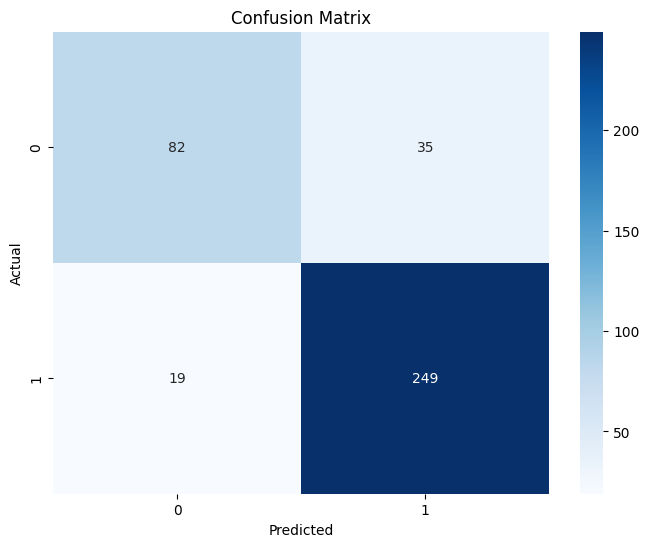

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()